In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/LANL-Earthquake-Prediction/sample_submission.csv
/kaggle/input/LANL-Earthquake-Prediction/train.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_fb8af5.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_a35c82.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_cec2f2.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_176542.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9c3d6a.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9e61da.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_afadfb.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_986976.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_ceab44.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_272a47.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_5ef47e.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_69787a.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_9f6315.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_6f2222.csv
/kaggle/input/LANL-Earthquake-Pr

**RNN with CNN feature extraction****

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

We will address when the earthquake will take place. Specifically we’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

Dataset Description
the dataset consists of seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each seg_id in the test folder, you should predict a single time_to_failure corresponding to the time between the last row of the segment and the next laboratory earthquake.

File descriptions

train.csv - A single, continuous training segment of experimental data.

test - A folder containing many small segments of test data.

sample_sumbission.csv - A sample submission file in the correct format.

**Data fields**

acoustic_data - the seismic signal

time_to_failure - the time (in seconds) until the next laboratory earthquake 

seg_id - the test segment ids for which predictions should be made (one prediction per segment)

In [2]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [3]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Concatenate, Average, Maximum, CuDNNLSTM, CuDNNGRU, Bidirectional, TimeDistributed
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine.input_layer import Input
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(7723)
tf.random.set_seed(1090)


In [4]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
%%time
train_df = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

CPU times: user 1min 26s, sys: 11 s, total: 1min 37s
Wall time: 3min 49s


I am using the earthquake data here. It is a time series data having two fields.

acoustic_data = the time when signal was generated at the epicenter
time_to_failure = the time taken in seconds when quake is felt on the surface of earth

In [6]:
reduce_mem_usage(train_df)

,acoustic_data,time_to_failure
0,12,1.4687500
1,6,1.4687500
2,8,1.4687500
3,5,1.4687500
4,8,1.4687500
...,...,...
629145475,7,9.7578125
629145476,9,9.7578125
629145477,10,9.7578125
629145478,6,9.7578125


In [7]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46875
1,6,1.46875
2,8,1.46875
3,5,1.46875
4,8,1.46875


In [8]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

In [9]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


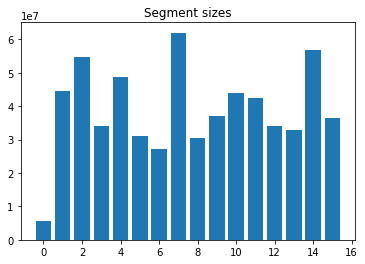

In [10]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

In [11]:
class EarthQuakeRandom(keras.utils.all_utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

In [12]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

Validating the data and calculate mean and standrad deviation on the training data.

In [13]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)


4.472289301190891 6.189013535612676


In [14]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [15]:
def CnnRnnModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = CuDNNGRU(24, return_sequences = False, return_state = False)(x)
    y = Dense(1)(x)

    return Model(inputs = [i], outputs = [y])

In [16]:
model = CnnRnnModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

2022-10-22 03:34:02.759365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 03:34:02.856648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 03:34:02.857402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 03:34:02.860245: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150000, 1)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15000, 8)          88        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 16)          1296      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 16)           2576      
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 24)                3024      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 7,009
Trainable params: 7,009
Non-trainable params: 0
___________________________________________________________

In [17]:
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 50, 
    verbose = 0, 
    validation_data = valid_gen,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
        ModelCheckpoint(filepath='cnn_rnn.h5', monitor='val_loss', save_best_only=True, verbose=1)]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-22 03:34:05.371307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-22 03:34:07.104876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: val_loss improved from inf to 2.38964, saving model to cnn_rnn.h5

Epoch 00002: val_loss did not improve from 2.38964

Epoch 00003: val_loss improved from 2.38964 to 2.34822, saving model to cnn_rnn.h5

Epoch 00004: val_loss improved from 2.34822 to 2.15601, saving model to cnn_rnn.h5

Epoch 00005: val_loss improved from 2.15601 to 2.12421, saving model to cnn_rnn.h5

Epoch 00006: val_loss did not improve from 2.12421

Epoch 00007: val_loss did not improve from 2.12421

Epoch 00008: val_loss did not improve from 2.12421

Epoch 00009: val_loss did not improve from 2.12421

Epoch 00010: val_loss did not improve from 2.12421
Epoch 00010: early stopping


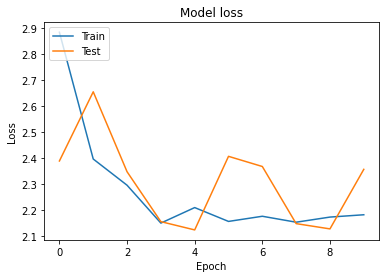

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [19]:
def load_test(ts_length = 150000):
    base_dir = '../input/LANL-Earthquake-Prediction/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [20]:
test_data, test_ids = load_test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == "__main__":


  0%|          | 0/2624 [00:00<?, ?it/s]

In [21]:
X_test = ((test_data - X_train_mean)/ X_train_std).astype('float32')
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

In [22]:
model = load_model('cnn_rnn.h5')

In [23]:
y_pred = model.predict(X_test)

2022-10-22 03:50:20.775630: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1574400000 exceeds 10% of free system memory.
2022-10-22 03:50:22.524825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1574400000 exceeds 10% of free system memory.


In [24]:
names = ['x', 'y', 'z']
index = pd.MultiIndex.from_product([range(s)for s in X_test.shape], names=names)
df = pd.DataFrame({'A': X_test.flatten()}, index=index)['X_test']

In [ ]:
!pip install xlsxwriter

In [ ]:
y_test_data = pd.DataFrame(X_test)
writer = pd.ExcelWriter("y-test-RNN.xlsx", engine='xlsxwriter')
y_test_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()

y_pred_data = pd.DataFrame(y_pred)
writer = pd.ExcelWriter("y_pred_RNN.xlsx", engine='xlsxwriter')
y_pred_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()